In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from tqdm import tqdm

llm_bots = [
    'GPTBot', 'Google-Extended', 'anthropic-ai', 
    'cohere-ai', 
    "Amazonbot", "FacebookBot", "Bytespider", "Yeti", 
    "YandexBot", 
    "Baiduspider", "360Spider", "PetalBot",
]

databroker_bots = [
    "CCBot", 
    "Omgilibot", 
]

rag_bots = [
    "Bingbot", 
    "ChatGPT-User", 
    "cohere-ai", 
    "PerplexityBot", 
    "YouBot", 
    "DuckDuckBot", 
]

seo_bots = [
    'Googlebot',
    'Slurp',
    'Applebot',
    # 'SemrushBot',
]

all_bots = llm_bots + databroker_bots + rag_bots + seo_bots
all_bots_lower = [bot.lower() for bot in all_bots] 
lower2original = dict(zip(all_bots_lower, all_bots))

## Aggregate scores for each bot

In [2]:
# Load the bias scores from the updated JSON file
bias_scores_file_path = '../measurement_data/bias_scores.json'
with open(bias_scores_file_path, 'r') as f:
    bias_scores = json.load(f)

# Aggregate scores
# Initialize a dictionary to hold the aggregate scores for each bot
aggregate_scores = defaultdict(lambda: defaultdict(int))

for url, bot_scores in tqdm(bias_scores.items()):
    for bot, score_info in bot_scores.items():
        bot_lower = bot.lower()
        if bot_lower in all_bots_lower:  # Filter bots based on all_llm_bots
            # Increment the count for the category of this bot
            aggregate_scores[lower2original[bot_lower]][score_info['category']] += 1

# Save the aggregated scores to a new JSON file for further analysis
aggregated_scores_file_path = 'aggregated_bias_scores.json'
with open(aggregated_scores_file_path, 'w') as f:
    json.dump(aggregate_scores, f, indent=4)

print("Aggregated bias scores have been saved.")


100%|██████████| 582216/582216 [00:01<00:00, 518505.84it/s]

Aggregated bias scores have been saved.


In [3]:
favorability_scores = {}
total_websites = len(bias_scores)

for bot, scores in aggregate_scores.items():
    favored = scores.get('favored', 0)
    disfavored = scores.get('disfavored', 0)
    nobias = scores.get('no bias', 0)

    favorability_score = ((favored)/(disfavored + favored))
    favorability_scores[bot] = favorability_score

# Sort bots by their favorability score in descending order
sorted_bots = sorted(favorability_scores.items(), key=lambda x: x[1], reverse=True)


## Favorability score ranking

In [4]:
# Print the ranked list
print("Bot Rank based on Favorability Score:")
for rank, (bot, score) in enumerate(sorted_bots, start=1):
    print(f"{rank}. {bot}: {score:.4f}")

Bot Rank based on Favorability Score:
1. Googlebot: 0.6540
2. DuckDuckBot: 0.5876
3. Bingbot: 0.4277
4. Applebot: 0.3629
5. Slurp: 0.2471
6. YandexBot: 0.1765
7. Yeti: 0.1176
8. FacebookBot: 0.0671
9. Baiduspider: 0.0640
10. Amazonbot: 0.0442
11. ChatGPT-User: 0.0299
12. 360Spider: 0.0232
13. Bytespider: 0.0160
14. PetalBot: 0.0157
15. PerplexityBot: 0.0146
16. GPTBot: 0.0128
17. Google-Extended: 0.0076
18. anthropic-ai: 0.0070
19. CCBot: 0.0066
20. cohere-ai: 0.0061
21. Omgilibot: 0.0055
22. YouBot: 0.0000


In [5]:
# Categorizing bots for plotting
categories = {
    'LLM Bots': llm_bots,
    'Databroker Bots': databroker_bots,
    'RAG Bots': rag_bots,
    'SEO Bots': seo_bots,
}

# Preparing data for plotting
scores_by_category = defaultdict(list)
for cat_name, bots in categories.items():
    bot = bot.lower()
    for bot in bots:
        if bot in favorability_scores:
            scores_by_category[cat_name].append((bot, favorability_scores[bot]))

# Sorting scores within each category
for cat in scores_by_category:
    scores_by_category[cat].sort(key=lambda x: x[1], reverse=True)

## Plot (Figure 6 in the paper)

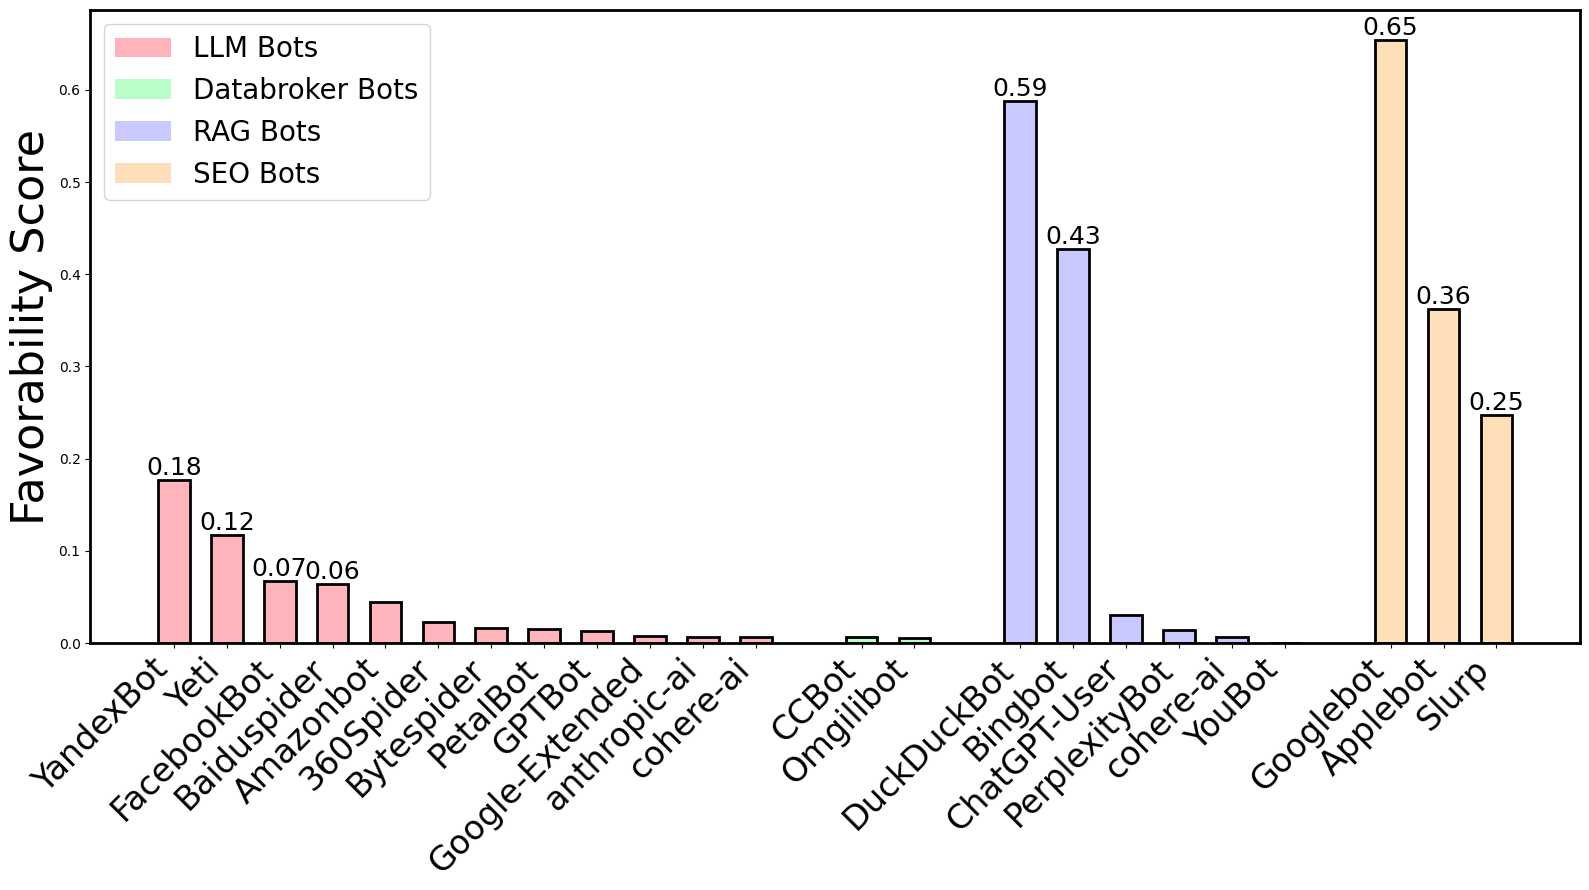

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Adjusted figure size for better detail
fig, ax = plt.subplots(figsize=(16, 9))

# Pastel colors for each category
category_colors = {
    'LLM Bots': '#ffb3ba',  # Pastel red
    'Databroker Bots': '#baffc9',  # Pastel green 
    'RAG Bots':  '#c9c9ff',  # Pastel purple
    'SEO Bots': '#ffdfba',  # Pastel orange
}

# Initialize lists to collect plot data
bot_positions = []
scores_list = []
bot_names = []
bar_colors = []

current_position = 0
for cat_name, scores in scores_by_category.items():
    for bot, score in scores:
        bot_positions.append(current_position)
        bot_names.append(bot)
        scores_list.append(score)
        bar_colors.append(category_colors[cat_name])  # Use category color
        current_position += 1
    current_position += 1  # Space between categories

# Plotting bars with category-specific colors
bars = ax.bar(bot_positions, scores_list, color=bar_colors, width=0.6, align='center', edgecolor='black', linewidth=2)

# Setting x-ticks with bot names and rotating them for clarity
ax.set_xticks(bot_positions)
ax.set_xticklabels(bot_names, rotation=45, ha='right', fontsize=24)

# Annotating bars with scores
for bar, score in zip(bars, scores_list):
    if score > 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{score:.2f}", 
                ha='center', va='bottom', fontsize=18)

# Enhancing the plot aesthetics
ax.set_axisbelow(True)

# Labels and title
ax.set_ylabel('Favorability Score', fontsize=32)

# Set the plot's borders thickness
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Create legend manually
legend_elements = [Patch(facecolor=color, label=label) for label, color in category_colors.items()]
ax.legend(handles=legend_elements, fontsize=20, loc='upper left', title_fontsize='24')

# save the plot
plt.tight_layout()
plt.savefig('plots/favorability_scores.pdf', dpi=300)
plt.show()

